In [1]:
import numpy as np
import pandas as pd
import PcmPy as pcm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(0, '..')
import globals as gl

In [2]:
dataset = ['stroke', 'intact']
tinfo = pd.read_csv('../data/baseline/tinfo.tsv', sep='\t')
medianB = tinfo[tinfo.group=='stroke'].w_b.median()
tinfo['severity'] = 'mild'
tinfo.loc[tinfo.w_b < medianB, 'severity'] = 'severe'
N = len(tinfo.subj_id.unique())

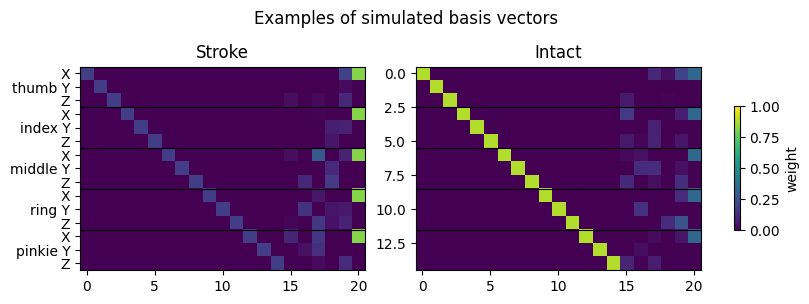

In [3]:
sn = 103
A_i = np.load(f'../data/basis_vectors/basis_vectors.intact.{sn}.npy')
A_s = np.load(f'../data/basis_vectors/basis_vectors.stroke.{sn}.npy')

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 3])
axs[1].imshow(A_i, vmin=0, vmax=1)
axs[0].imshow(A_s, vmin=0, vmax=1)
axs[0].set_title('Stroke')
axs[1].set_title('Intact')
axs[0].set_yticks(np.arange(0, A_i.shape[0]))
axs[0].set_yticklabels(gl.channels)
for ax in axs:
    for i in [2.5, 5.5, 8.5, 11.5]:
        ax.axhline(i, color='k', lw=.8)

cax = axs[0].get_images()[0]
cbar = fig.colorbar(cax, ax=axs, orientation='vertical', fraction=.01)
cbar.set_label('weight')

fig.suptitle('Examples of simulated basis vectors')

plt.show()

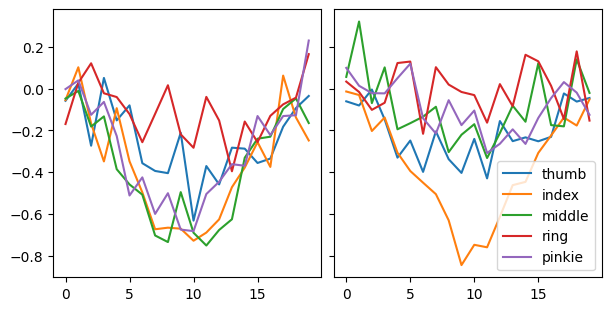

In [4]:
X_i = np.load(f'../data/baseline/single_finger.pretraining.intact.{sn}.npy')
X_s = np.load(f'../data/baseline/single_finger.pretraining.stroke.{sn}.npy')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=[6, 3])
tr = 6
axs[0].plot(X_s[tr, ::5, ::3])
axs[1].plot(X_i[tr, ::5, ::3])
axs[1].legend(['thumb', 'index', 'middle', 'ring', 'pinkie'])
plt.show()

In [17]:
euc = np.zeros((2, N, 5, 6, 6)) # (groups, n_subj, n_finger, dir, dir)
cos = np.zeros_like(euc)
for d, ds in enumerate(dataset):
    for f, fi in enumerate(tinfo.finger.unique()):
        for s, sn in enumerate(tinfo.subj_id.unique()):
            tinfo_s = tinfo[(tinfo.subj_id == sn) & (tinfo.group == ds)]
            X = np.load(f'../data/baseline/single_finger.pretraining.{ds}.{sn}.npy') # (trials, time, channels)
            X_f = X[tinfo_s.finger == f, 50] #.mean(axis=1)
            X_m = X_f.reshape(6, -1, 15).mean(axis=1)
            G = X_m @ X_m.T
            diag = np.diag(G)
            norm = np.sqrt(np.outer(diag, diag))
            D2 = diag[:, None] + diag[None, :] - 2 * G
            euc[d, s, f] = np.sqrt(D2)
            cos[d, s, f] = 1 - G / norm

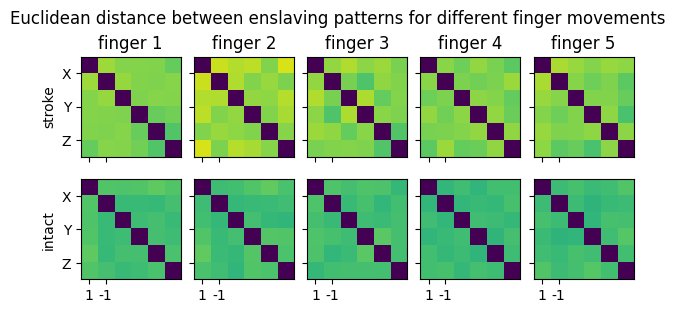

In [18]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, constrained_layout=True, figsize=[6, 3])

for d, ds in enumerate(dataset):
    for f, fi in enumerate(tinfo.finger.unique()):
        ax = axs[d, f]
        ax.imshow(euc[d, :, f].mean(axis=0), vmin=0, vmax=.5)
        ax.set_title(f'finger {fi + 1}') if d == 0 else None
        ax.set_yticks([0.5, 2.5, 4.5])
        ax.set_yticklabels(['X', 'Y', 'Z'])
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['1', '-1'])
        ax.set_ylabel(ds) if f == 0 else None

fig.suptitle('Euclidean distance between enslaving patterns for different finger movements')

plt.show()

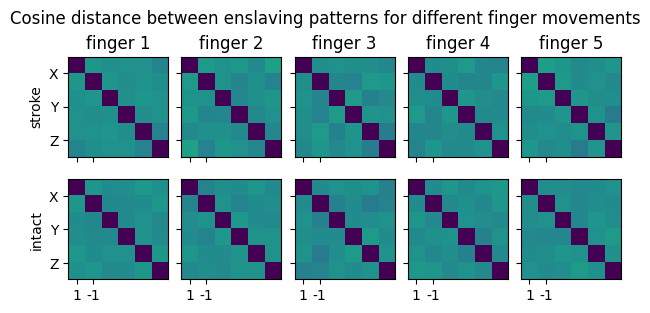

In [19]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, constrained_layout=True, figsize=[6, 3])

for d, ds in enumerate(dataset):
    for f, fi in enumerate(tinfo.finger.unique()):
        ax = axs[d, f]
        ax.imshow(cos[d, :, f].mean(axis=0), vmin=0, vmax=2)
        ax.set_title(f'finger {fi + 1}') if d == 0 else None
        ax.set_yticks([0.5, 2.5, 4.5])
        ax.set_yticklabels(['X', 'Y', 'Z'])
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['1', '-1'])
        ax.set_ylabel(ds) if f == 0 else None

fig.suptitle('Cosine distance between enslaving patterns for different finger movements')

plt.show()

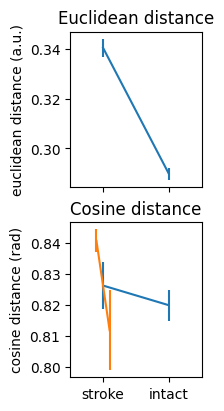

In [20]:
tinfo_g = tinfo.groupby(['subj_id', 'group', 'severity']).mean(numeric_only=True).reset_index()
w_b_s = tinfo_g[tinfo_g['group'] == 'stroke'].w_b.to_numpy()
w_b_i = tinfo_g[tinfo_g['group'] == 'intact'].w_b.to_numpy()

euc_p = euc.mean(axis=(2, 3, 4))
euc_avg = euc_p.mean(axis=1)
euc_err = euc_p.std(axis=1) / np.sqrt(N)
cos_p = cos.mean(axis=(2, 3, 4))
cos_avg = cos_p.mean(axis=1)
cos_err = cos_p.std(axis=1) / np.sqrt(N)

cos_mild = cos_p[0, tinfo_g[tinfo_g.group=='stroke'].severity=='mild']
cos_severe = cos_p[0, tinfo_g[tinfo_g.group=='stroke'].severity=='severe']
cos_sg_avg = np.r_[cos_severe.mean(), cos_mild.mean()]
cos_sg_err = np.r_[cos_severe.std() / np.sqrt(len(tinfo_g[tinfo_g.severity=='severe'])),
                    cos_mild.std() / np.sqrt(len(tinfo_g[tinfo_g.severity=='mild']))]

fig, axs = plt.subplots(2, constrained_layout=True, figsize=[2, 4], sharex=True)

axs[0].errorbar(dataset, euc_avg, yerr=euc_err)
axs[0].set_title('Euclidean distance')
axs[0].set_ylabel('euclidean distance (a.u.)')
axs[1].errorbar(dataset, cos_avg, yerr=cos_err)
axs[1].errorbar([-.1, 0.1], cos_sg_avg, yerr=cos_sg_err)
axs[1].set_xlim(-.5, 1.5)
axs[1].set_title('Cosine distance')
axs[1].set_ylabel('cosine distance (rad)')

plt.show()

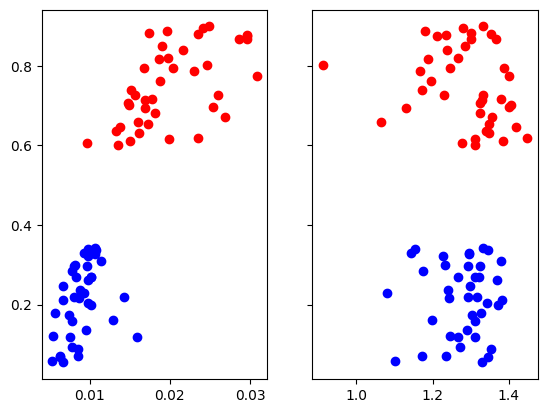

In [60]:
fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].scatter(euc_p[0], w_b_s, color='r')
axs[0].scatter(euc_p[1], w_b_i, color='b')
axs[1].scatter(cos_p[0], w_b_s, color='r')
axs[1].scatter(cos_p[1], w_b_i, color='b')

plt.show()

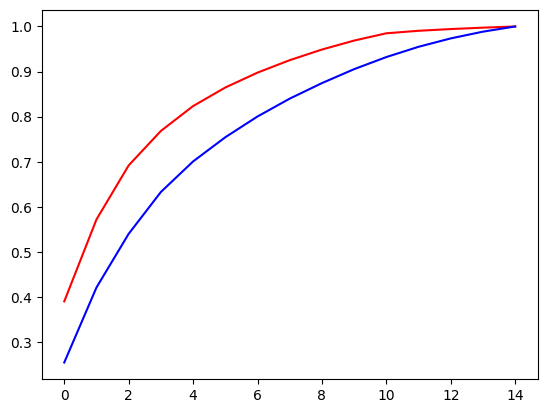

In [55]:
scaler = StandardScaler()
pca = PCA()
var_expl = np.zeros((2, N, 15)) # (groups, n_subj, n_channels)
for d, ds in enumerate(dataset):
    for s, sn in enumerate(tinfo.subj_id.unique()):
        tinfo_s = tinfo[(tinfo.subj_id == sn) & (tinfo.group == ds)]
        X = np.load(f'../data/baseline/single_finger.pretraining.{ds}.{sn}.npy') # (trials, time, channels)
        X_r = X.reshape(-1, X.shape[-1])
        X_norm = scaler.fit_transform(X_r)
        pca.fit(X_norm)
        var_expl[d, s] = pca.explained_variance_ratio_

fig, ax = plt.subplots()

ax.plot(np.cumsum(var_expl[0].mean(axis=0)), color='r', label='stroke')
ax.plot(np.cumsum(var_expl[1].mean(axis=0)), color='b', label='intact')

plt.show()